In [28]:
import ast
from collections import Counter, defaultdict
from copy import deepcopy
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
import numpy as np
import pandas as pd
import random
import re
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import spacy
import torch
from torch import Tensor
from torch.nn import Linear, Module, MSELoss
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from typing import Callable, Dict, List, Optional, Set, Tuple

In [68]:
def get_arg_max_real(x):
    index = 0
    M = -np.inf
    for i in range(len(x)):
        if np.real(x[i])> M:
            M = np.real(x[i])
            index=i
    return index

def get_arg_max_modulus(x):
    index = 0
    M = -np.inf
    for i in range(len(x)):
        if x[i]>= M:
            M = x[i]
            index=i
    return index

def get_leading_eigenvector(B):
    [vals,vecs] = np.linalg.eig(B)
    # If no positive eigenvalues, to within round off error
    if all(v < 1e-4 for v in list(vals)): 
        ones = np.ones((1,len(B))) / np.sqrt(len(B)) # Normalized vector of all 1's
        max_vec = ones[0,:]
    else:
        arg_max = get_arg_max_real(vals)
        max_vec = np.real(vecs[:,arg_max])
    return max_vec

def get_principal_eigenvector(A):
    [vals,vecs] = np.linalg.eig(A)
    arg_max = get_arg_max_modulus(vals)
    max_vec = vecs[:,arg_max]
    return max_vec

def get_shores_from_eigenvector(nodes,x):
    shore1 = set()
    shore2 = set()
    for node in nodes:
        if x[node] < 0: shore1.add(node)
        else: shore2.add(node)
    return [shore1, shore2]

def get_two_fiedler_eigenvectors(L):
    [evals, evecs] = np.linalg.eig(L)
    sorted_indices = np.argsort(evals)
    two_smallest_nonzero = []
    for i in sorted_indices:
        if evals[i] ==0: continue
        two_smallest_nonzero.append(i)
        if len(two_smallest_nonzero) == 2: break
    print(two_smallest_nonzero)
    fiedler1 = evecs[:,two_smallest_nonzero[0]]
    fiedler2 = evecs[:,two_smallest_nonzero[1]]
    return fiedler1, fiedler2

def get_largest_vectors(A):
    [evals, evecs] = np.linalg.eig(A)
    evals = [0 if np.abs(v) < 1e-5 else np.round(np.abs(v),1) for v in evals]
    sorted_indices = np.argsort(evals)
    two_largest_nonzero = []
    for i in np.flip(sorted_indices):
        two_largest_nonzero.append(i)
        if len(two_largest_nonzero) == 2: break
    big1 = np.real(evecs[:,two_largest_nonzero[0]])
    big2 = np.real(evecs[:,two_largest_nonzero[1]])
    return big1, big2

def form_encoding(vector1, vector2):
    z = np.zeros((len(vector1),2))
    for i in range(len(vector1)):
        z[i,0] = vector1[i]
        z[i,1] = vector2[i]
    return z

def get_clusters(embedding, num_clusters=4):
    kmeans = KMeans(
        init="random",
        n_clusters=num_clusters,
        n_init=10,
        random_state=1234
        )
    kmeans.fit(embedding)
    return kmeans

def get_colors_from_clusters(embedding, kmeans=None, num_clusters = 4):
    if kmeans is None:
        kmeans = get_clusters(embedding, num_clusters=num_clusters)
        labels = kmeans.labels_
    else:
        labels = kmeans.predict(embedding)
    color_template = plt.cm.tab10(np.linspace(0, 1, num_clusters))
    color = [color_template[x] for x in list(labels) ]
    return color

class graphHandler:
    def __init__(self, G, colormap, use_pydot = True, reset_labels = False):
        if reset_labels:
            self.G = nx.convert_node_labels_to_integers(G)

        else:
            self.G = G

        self.color_template = self.color_template = ['y', 'b', 'm', 'c', 'k'] 
        self.color_map = colormap
        if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')
        else: self.pos = nx.nx_agraph.graphviz_layout(self.G,prog='neato')
    ####################
    ## Public methods ##
    ####################
    def getGraph(self): return self.G
    def showGraph(self,agent_colors = None,title = None, with_labels = False, legend = None):
        if agent_colors == None: agent_colors = self.color_map
        if title == None: title = "Network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        if with_labels:
            nx.draw(self.G,self.pos,node_color = agent_colors, with_labels = with_labels, node_size = 200, alpha=0.8)
        else:
            nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
        if legend is not None:
            plt.legend(handles = legend, loc = 'best')
        plt.show()
    def showLouvainCommunities(self, title = None):
        agent_colors = self._getAgentColors_from_LouvainCommunities()
        if title == None: title = "Louvain communities for network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
        plt.show()
    def showDendrogram(self):
        myHandler = DendrogramHandler(self.G)
        Z = myHandler.getLinkMatrix()
        ZLabels = myHandler.getLinkMatrixLabels()
        #plt.figure(figureNumber);plt.clf()
        dendrogram(Z, labels=ZLabels)
        del myHandler
    def show_kCores(self):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # compute position of each node with shell layout
        nlist = []
        for k in sorted(kcores.keys(),reverse=True):
            nlist.append(kcores[k])
        pos = nx.layout.shell_layout(self.G, nlist = nlist)
        colors = ['black','lightblue','yellow','magenta','olive', 'cyan', 'red']
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(list(kcores.keys()),reverse = True):
            nodes = kcores[kcore]
            color = colors[kcore%len(colors)]
            nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=color)
            label = f"kcore = {kcore}"
            legend_elements.append(Line2D([0], [0], marker='o', color=color, label=label,markerfacecolor=color, markersize=15))
        nx.draw_networkx_edges(self.G, pos, width=0.2)
        nx.draw_networkx_labels(self.G, pos)
        plt.title("K-core layout of network")
        plt.legend(handles = legend_elements, loc = 'best')

    def show_kCores_by_partition(self, colors, title = "K-core of Network"):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # Shapes
        shapes = ["o", "v", "s", "*", "+", "d"]

        # compute position of each node with shell layout
        nlist = []
        for k in sorted(kcores.keys(),reverse=True):
            nlist.append(kcores[k])
        pos = nx.layout.shell_layout(self.G, nlist = nlist)
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(kcores.keys(),reverse=True):
            nodes = kcores[kcore]
            shape = shapes[kcore%len(shapes)]
            
            #nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=colors[nodes[0]], node_shape=shape, alpha = 0.5, node_size=90)
            for node in nodes:
                nx.draw_networkx_nodes(self.G, pos, nodelist=[node], node_color=colors[node], node_shape=shape, alpha = 0.5, node_size=90)
            label = f"kcore = {kcore}"
            legend_elements.append(Line2D([0], [0], marker=shape, color='k', markerfacecolor = 'w', label=label, markersize=10))
        
        nx.draw_networkx_edges(self.G, pos, width=0.1)
        #nx.draw_networkx_labels(self.G, pos)
        plt.title(title)
        plt.legend(handles = legend_elements, loc = 'best')

    def show_partitions(self, partition_list, title = "Network colored by partitions"):
        plt.figure()
        plt.axis('off')
        for i in range(len(partition_list)):
            nx.draw_networkx_nodes(partition_list[i],self.pos,node_color=self.color_template[i%len(self.color_template)], alpha = 0.8)
        for edge in self.G.edges:
            self._draw_edge_by_type(edge, partition_list)
        nx.draw_networkx_labels(self.G,self.pos)
        if len(partition_list) == 0:
            mod = 0
        else:
            mod = nx.algorithms.community.quality.modularity(self.G,partition_list)
        title = title + ": Modularity = " + str(np.round(mod,2))
        plt.title(title)
    
    #####################
    ## Private methods ##
    #####################
    def _getAgentColors_from_LouvainCommunities(self):
        """ Use the Louvain partition method to break the graph into communities """
        # Louvain method pip install python-louvain
        # see https://arxiv.org/pdf/0803.0476.pdf
        # see https://github.com/taynaud/python-louvain
        color_map = self.color_map
        set_of_partitions = nx.community.louvain_communities(self.G)
        print(f"The Louvain algorithm found {len(set_of_partitions)} partitions.")
        partition_number = 0
        for partition in set_of_partitions:
            # print(f"Partition {partition_number} is {partition}")
            for node in partition:
                color_map[node] = self.color_template[partition_number%len(self.color_template)]
            partition_number += 1
        return color_map
    def _draw_edge_by_type(self, edge, partition):
        edge_style = 'dashed'
        for part in partition:
            if edge[0] in part and edge[1] in part:
                edge_style = 'solid'
                break
        nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)

    def get_louvain_communities(self):
        return nx.community.louvain_communities(self.G)

def read_data(folder_path: str = './final_project_files') -> Tuple[pd.DataFrame, pd.DataFrame]:
    nodes_file = f'{folder_path}/cs324_W2024_data_nodes.csv'
    edges_file =  f'{folder_path}/cs324_W2024_data_edges.csv'
    nodes_data = pd.read_csv(nodes_file)
    edges_data = pd.read_csv(edges_file)

    nodes_data['data'] = nodes_data['data'].apply(ast.literal_eval)
    types, values = [], []

    for node_data in nodes_data['data']:
        types.append(node_data['type'])

        if 'role' in node_data:
            values.append(node_data['role'])

        else:
            values.append(node_data['name'])

    nodes_data['type'] = types
    nodes_data['value'] = values
    nodes_data.drop(columns=['data'], inplace=True)

    edges_data.rename(columns={'type': 'edge_type'}, inplace=True)
    
    return nodes_data, edges_data

def create_graph(nodes_data: pd.DataFrame, edges_data: pd.DataFrame, show_graph: bool = False) -> graphHandler:
    # Use nodes and edges to create the graph
    G = nx.Graph()
    message_node_id = 0
    message_node_types, message_node_values = {}, {}

    for i in nodes_data.index:
        source, target = edges_data['source'][i], edges_data['target'][i]
        edge_type, content = edges_data['edge_type'][i], edges_data['content'][i]

        if source != target: # Don't include self loops
            # Don't add a message node if the edge represents a thread in a channel
            if edge_type == 'thread_in_channel':
                G.add_edge(source, target, **{'edge_type': 'thread_in_channel'})

            # Otherwise, add a message node
            else:
                message_node_id += 1
                new_id = str(message_node_id)
                message_edge_type = 'message_in_channel' if edge_type == 'posted_in_channel' else ('message_in_thread' if edge_type == 'posted_in_thread' else 'message_to')
                G.add_edge(source, new_id, **{'edge_type': 'posted_message'})
                G.add_edge(new_id, target, **{'edge_type': message_edge_type})
                message_node_types[new_id] = 'message'
                message_node_values[new_id] = content


    # Add node types and values
    node_type_dict = {nodes_data['node'][i]: nodes_data['type'][i] for i in nodes_data.index}
    node_value_dict = {nodes_data['node'][i]: nodes_data['value'][i] for i in nodes_data.index}
    nx.set_node_attributes(G, node_type_dict, 'node_type')
    nx.set_node_attributes(G, message_node_types, 'node_type')
    nx.set_node_attributes(G, node_value_dict, 'node_value')
    nx.set_node_attributes(G, message_node_values, 'node_value')

    # Wrap the graph in a graph handler (gives us extra functionality)
    graph_handler = graphHandler(G, ['y' for _ in G.nodes], use_pydot=False)

    if show_graph:
        colors = []
        H = graph_handler.getGraph() # Get graph sorted by value
        color_map = ['y', 'm', 'c', 'b', 'g', 'k']
        types = list(set(list(node_type_dict.values()) + ['message']))
        type_colors = {types[i]: color_map[i%len(color_map)] for i in range(len(types))}
        legend_elements = []

        for node_type in type_colors.keys():
            legend_elements.append(Line2D([0], [0], marker='o', color=type_colors[node_type], markerfacecolor = type_colors[node_type], label=node_type, markersize=10))

        for node in H.nodes:
            colors.append(type_colors[G.nodes[node]['node_type']])

        graph_handler.showGraph(title='CS 236 Discord Graph', agent_colors=colors, legend=legend_elements)

    return graph_handler

# Projection 1
def remove_nodes(handler: graphHandler, node_types_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    # If we're removing messages, add edges between people and the message destination first - some or all of the destinations 
    # might be removed later in the projection, but that's ok
    if 'message' in node_types_to_remove:
        for u, v in graph_copy.edges:
            if graph_copy.nodes[u]['node_type'] == 'person' and graph_copy.nodes[v]['node_type'] == 'message':
                message_neighbors = list(graph_copy.neighbors(v))
                assert len(message_neighbors) == 2  # A message should only go to another person, a channel, or a thread
                message_neighbor = message_neighbors[0] if message_neighbors[0] != u else message_neighbors[1]
                assert message_neighbor != u
                message_neighbor_type = graph_copy.nodes[message_neighbor]['node_type']
                new_edge_type = 'replied_to' if message_neighbor_type == 'person' else ('posted_in_channel' if message_neighbor_type == 'channel' else 'posted_in_thread')
                graph_copy.add_edge(u, message_neighbor, **{'edge_type': new_edge_type})

    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_type'] in node_types_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 1
def remove_nodes_by_value(handler: graphHandler, node_values_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_value'] in node_values_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 2
def remove_edges(handler: graphHandler, edge_types_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())

    # Add sender information if we're removing posted message edges (in cass we want to filter message nodes by sender)
    if 'posted_message' in edge_types_to_remove:
        for u, v, attrs in graph_copy.edges(data=True):
            if attrs['edge_type'] == 'posted_message':
                if graph_copy.nodes[u]['node_type'] == 'person' and graph_copy.nodes[v]['node_type'] == 'message':
                    graph_copy.nodes[v]['sender'] = u

                else:
                    graph_copy.nodes[u]['sender'] = v

    graph_copy.remove_edges_from([edge for edge in graph_copy.edges if graph_copy.edges[edge]['edge_type'] in edge_types_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 3
def remove_singletons(handler: graphHandler) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if nx.degree(graph_copy, node) < 1])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 4
def add_new_relationship(handler: graphHandler, direct_relationship_edge_type: Optional[str], node_types_to_remove: Set[object], reset_labels: bool = False) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())

    # Create bi-partite graph by removing edges that represent direct relationships
    direct_relationship_edges = []  # We'll need to add these back at the end

    if direct_relationship_edge_type is not None:
        for u, v, attrs in list(graph_copy.edges(data=True)):
            if attrs['edge_type'] == direct_relationship_edge_type:
                graph_copy.remove_edge(u, v)
                direct_relationship_edges.append((u, v))

    # Calculate the two-step paths matrix
    A = nx.adjacency_matrix(graph_copy).toarray()
    two_step_paths = A @ A

    # Remove self-loops
    np.fill_diagonal(two_step_paths, 0)

    # Add edges between nodes based on the two-step path matrix
    nodes = list(graph_copy.nodes())

    for i in range(len(two_step_paths)):
        for j in range(len(two_step_paths[0])):
            node_1, node_2 = nodes[i], nodes[j]

            if two_step_paths[i][j] > 0:
                graph_copy.add_edge(node_1, node_2)

    # Add back the edges that represent direct relationships
    graph_copy.add_edges_from(direct_relationship_edges)

    # Remove any unwanted nodes and singletons
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_type'] in node_types_to_remove])
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if nx.degree(graph_copy, node) < 1])

    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False, reset_labels=reset_labels)

    return projected_graph_handler

def show_eigenvector_communities(handler: graphHandler, with_labels: bool = False, num_clusters: int = 3) -> None:
    graph = handler.getGraph()
    A = nx.adjacency_matrix(graph).toarray()
    v1, v2 = get_largest_vectors(A)
    embedding = form_encoding(v1, v2)
    colors = get_colors_from_clusters(embedding, num_clusters=num_clusters)
    plt.scatter(embedding[:,0], embedding[:,1],s=100,alpha = 0.8, color = colors)
    plt.title('Eigenvector Embeddings')
    plt.show()
    handler.showGraph(title='Eigenvector Communities', agent_colors=colors, with_labels=with_labels)

def who_interacted_with_whom(handler: graphHandler) -> graphHandler:
    projected_graph_handler = remove_nodes(handler, set(['channel', 'message']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] != 'channel' and attrs['node_type'] != 'message'
    projected_graph_handler = remove_singletons(projected_graph_handler)
    projected_graph_handler = add_new_relationship(projected_graph_handler, 'replied_to', set(['thread']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] == 'person'

    return projected_graph_handler

def message_interactions(handler: graphHandler) -> graphHandler:
    edges_to_remove = set(['thread_in_channel', 'posted_message'])
    projected_graph_handler = remove_edges(handler, edges_to_remove)
    for _, _, attrs in projected_graph_handler.getGraph().edges(data=True):
        assert attrs['edge_type'] not in edges_to_remove
    projected_graph_handler = remove_singletons(projected_graph_handler)
    projected_graph_handler = add_new_relationship(projected_graph_handler, None, set(['person', 'channel', 'thread']), reset_labels=True)
    for node, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] == 'message' and nx.degree(projected_graph_handler.getGraph(), node) >= 1

    return projected_graph_handler

def who_interacted_with_whom_just_students(handler: graphHandler) -> graphHandler:
    projected_graph_handler = remove_nodes(handler, set(['channel', 'message']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] != 'channel' and attrs['node_type'] != 'message' 
    projected_graph_handler = remove_nodes_by_value(projected_graph_handler, set(['TA', 'Instructor']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        if attrs['node_type'] == 'person':
            assert attrs['node_value'] == 'Student'
    projected_graph_handler = remove_singletons(projected_graph_handler)
    projected_graph_handler = add_new_relationship(projected_graph_handler, 'replied_to', set(['thread']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] == 'person'

    return projected_graph_handler

def clean_message(nlp, message: str) -> List[str]:
    doc = nlp(message)
    clean_tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    message_clean = ' '.join(clean_tokens)

    return message_clean

def vectorize_message(nlp, message: str) -> np.array:
    message_clean = clean_message(nlp, message)
    
    return nlp(message_clean).vector

def get_message_gcn_data(nlp, handler: graphHandler, hand_labels: Optional[Dict[object, int]] = None) -> Tuple[np.array, np.array]:
    graph = handler.getGraph()
    x, y = [], []
    communities = handler.get_louvain_communities()
    node_to_community_map = {node: community 
                             for community, nodes in enumerate(communities) 
                             for node in nodes}

    for node, attrs in graph.nodes(data=True):
        assert attrs['node_type'] == 'message'
        message = attrs['node_value']
        x.append(vectorize_message(nlp, message))

        if hand_labels is None:
            # Default to communities as labels
            y.append(node_to_community_map[node])

        else:
            y.append(hand_labels.get(node, 0))

    return np.array(x), np.array(y)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels_1, hidden_channels_2, hidden_channels_3, output):
        super().__init__()
        torch.manual_seed(1234)
        self.hidden_layer_1 = GCNConv(300, hidden_channels_1)
        self.hidden_layer_2 = GCNConv(hidden_channels_1, hidden_channels_2)
        self.hidden_layer_3 = GCNConv(hidden_channels_2, hidden_channels_3)
        self.output_layer = Linear(hidden_channels_3, output)

    def forward(self, x, edge_index):
        h = self.hidden_layer_1(x, edge_index)
        h = h.relu()
        h = self.hidden_layer_2(h, edge_index)
        h = h.relu()
        h = self.hidden_layer_3(h, edge_index)
        h = h.relu()

        out = self.output_layer(h)

        return out, h

def train_model(data, model, n_epochs: int = 1000, semi_supervised: bool = False):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    def _train(data):
        optimizer.zero_grad()  # Clear gradients.
        out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        return loss, h

    for epoch in range(n_epochs):
        loss, embedding = _train(data)

    predictions, _ = model(data.x, data.edge_index)

    if semi_supervised:
        predictions = predictions[data.train_mask]
        predicted_labels = torch.argmax(predictions, dim=1)
        correct_predictions = (predicted_labels == data.y[data.train_mask]).sum().item()

    else:
        predicted_labels = torch.argmax(predictions, dim=1)
        correct_predictions = (predicted_labels == data.y).sum().item()
        
    accuracy = correct_predictions / len(data.y)

    print(f'Final loss: {loss.item()}')
    print(f'Final accuracy: {accuracy}')

    return embedding

def visualize(h, y, label_mapping: Optional[Dict[object, str]] = None):
    def _extract_nodes_by_class(data, class_number):
        index_list = []
        for index, _ in enumerate(data):
            if data[index] == class_number:
                index_list.append(index)
        return index_list

    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    classes = set(np.unique(y))

    colorlist = plt.cm.tab10(np.linspace(0, 1, len(classes)))

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    class_labels = []

    for class_number in classes:
        index_list = _extract_nodes_by_class(y, class_number)
        plt.scatter(z[index_list, 0], z[index_list, 1], s=70, color=colorlist[class_number])

        if label_mapping is not None:
            class_labels.append(label_mapping[class_number])

    if label_mapping is not None:
        plt.legend(class_labels, bbox_to_anchor=(1, 1), loc='upper left')
        
    plt.show()

def visualize_with_edges(handler, embedding):
    communities = handler.get_louvain_communities()
    nodes_dict = {node: community 
                        for community, nodes in enumerate(communities) 
                        for node in nodes}
    colorlist = plt.cm.tab10(np.linspace(0, 1, len(communities)))
    z = TSNE(n_components=2).fit_transform(embedding.detach().cpu().numpy())
    G = handler.getGraph()
    pos = nx.spring_layout(G)
    i=0
    for node in pos.keys():
        pos[node] = [z[i,0], z[i,1]]
        i = i + 1
    plt.figure(figsize = (10, 10))
    labellist = list(nodes_dict.values())
    for class_number in set(nodes_dict.values()):
            nodelist = [key for key,val in nodes_dict.items() if val == class_number]
            positions = {key:val for key, val in pos.items() if key in nodelist}
            node_sizes = [50 for key, val in dict(G.degree).items() if key in nodelist]
            nx.draw_networkx_nodes(G, pos=positions, nodelist=nodelist, 
                                node_size = node_sizes, node_color = colorlist[class_number], 
                                label=nodes_dict[class_number])

    nx.draw_networkx_edges(G, pos, width=0.25)
    plt.show()

def create_pytorch_data(graph, x, y, training_percentage=0.5, hand_labels: Optional[Dict[object, int]] = None):
    data = from_networkx(graph)
    data.x = Tensor(x)

    mask = [False for node in graph.nodes]
    i = 0
    for node in graph.nodes:
        if (hand_labels is None and random.random() <= training_percentage) or (hand_labels is not None and node in hand_labels):
            mask[i] = True
        i += 1
    data.y = torch.tensor(y, dtype=torch.uint8)
    data.train_mask = torch.tensor(mask, dtype=bool)

    return data

def find_optimal_k(embeddings: np.array, show_plot: bool = False) -> int:
    k_range, silhouette_scores = range(2, 16), []

    for k in k_range:
        kmeans = get_clusters(embeddings, num_clusters=k)
        silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

    if show_plot:
        plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
        plt.title('Silhouette Scores for Different Values of K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Silhouette Score')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()

    # Find the optimal k based on the highest silhouette score
    return k_range[np.argmax(silhouette_scores)]

def show_message_embeddings_communities(message_embeddings: np.array, kmeans, n_clusters) -> None:
    colors = get_colors_from_clusters(message_embeddings, kmeans, num_clusters=n_clusters)
    plt.scatter(message_embeddings[:,0], message_embeddings[:,1], s=100, alpha=0.8, color=colors)
    plt.title('Message Embeddings')
    plt.show()

def print_cluster_messages(labels, indices, cluster, graph):
    cluster_messages = [i for i, label in enumerate(labels) if i in indices and label == cluster]
    print(f'CLUSTER {cluster}')
    for node in cluster_messages:
        print('---------------------------------------------------------------')
        print(graph.nodes[node]['node_value'])
        print('---------------------------------------------------------------\n')

def print_cluster_counts(kmeans, indices, top_n):
    message_clusers = kmeans.labels_[indices]
    message_cluster_counts = Counter(message_clusers)
    tuples_list = [(value, count) for value, count in message_cluster_counts.items()]
    tuples_list.sort(key=lambda x: x[1], reverse=True)
    print(tuples_list[:top_n])

def eigenvector_centrality(handler: graphHandler, node_attribute: str = 'node_value', node_filter_val: Optional[str] = None) -> None:
    graph = handler.getGraph()
    centrality = nx.eigenvector_centrality(graph)

    for node, cent in sorted(centrality.items(), key=lambda x: x[1], reverse=True):
        node_type = graph.nodes[node][node_attribute]

        if node_filter_val is None or node_type == node_filter_val:
            print(f'{node}, {node_type}: {cent}')

def group_messages_by_clusters(embeddings: np.array, messages: List[str], n_clusters: int) -> List[List[str]]:
    embeddings_k_means = get_clusters(embeddings, num_clusters=n_clusters)
    cluster_assignments = embeddings_k_means.labels_
    messages_by_cluster = [[] for _ in range(n_clusters)]

    for i, message in enumerate(messages):
        message_cluster = cluster_assignments[i]
        messages_by_cluster[message_cluster].append(message)

    return messages_by_cluster

In [3]:
spacy.cli.download('en_core_web_md')
nlp = spacy.load('en_core_web_md') 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 6.8 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


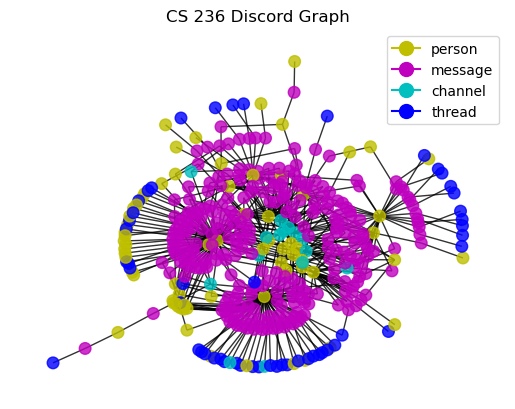

In [62]:
nodes_data, edges_data = read_data()
graph_handler = create_graph(nodes_data, edges_data, show_graph=True)

### Who was the most influential TA?

In [63]:
who_interacted_with_whom_handler = who_interacted_with_whom(graph_handler)

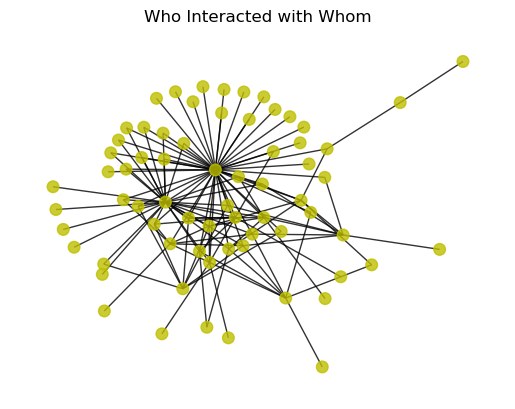

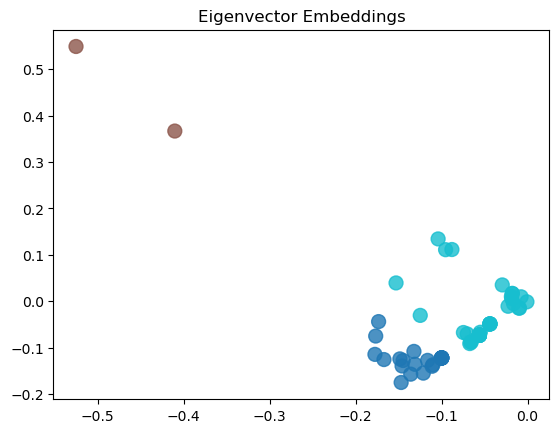

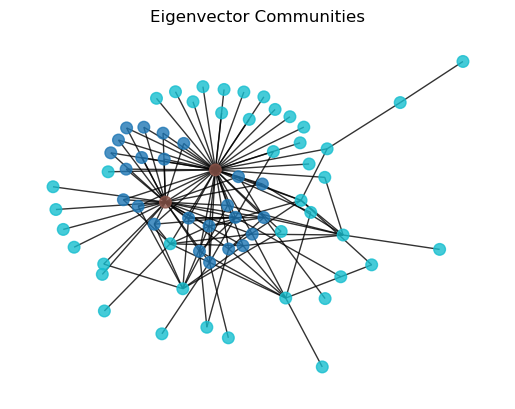

In [70]:
who_interacted_with_whom_handler.showGraph(title='Who Interacted with Whom')
show_eigenvector_communities(who_interacted_with_whom_handler)

In [71]:
eigenvector_centrality(who_interacted_with_whom_handler, node_filter_val='TA')

195069161412893074299514468536466378104, TA: 0.410238033341484
12563841620459862337423867749985313687, TA: 0.1732768796590112
252122291372972891917685148986981375101, TA: 0.09539516576997735
239340221307785601016176638108857773708, TA: 0.08802940827807766


There is one TA that is significantly more influential than the others, similar to what we saw with the 236 graph.

### Who were the most influential students?

In [72]:
who_interacted_with_whom_just_students_handler = who_interacted_with_whom_just_students(graph_handler)

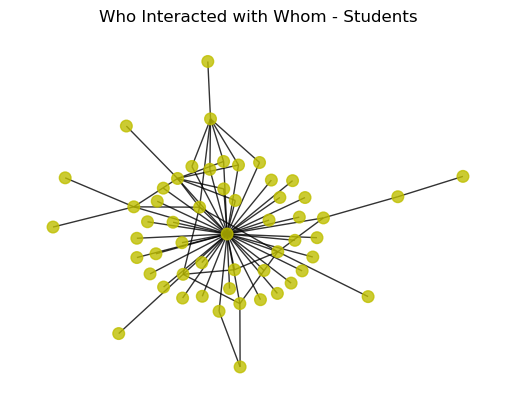

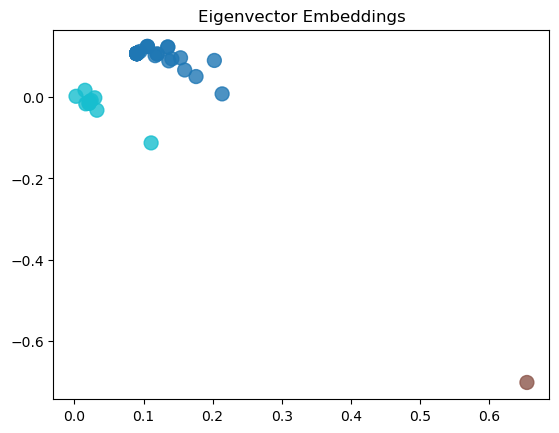

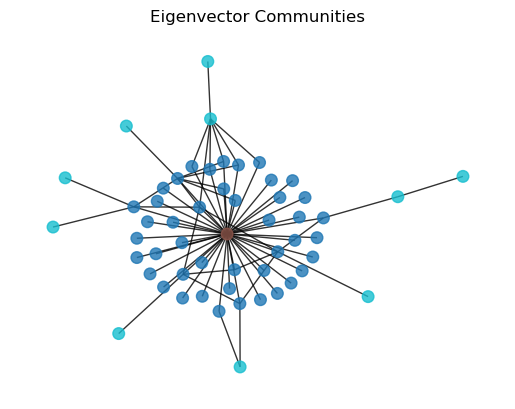

In [73]:
who_interacted_with_whom_just_students_handler.showGraph(title='Who Interacted with Whom - Students')
show_eigenvector_communities(who_interacted_with_whom_just_students_handler)

In [74]:
eigenvector_centrality(who_interacted_with_whom_just_students_handler)

142838701429072772128655441259243143722, Student: 0.6547523628019254
83544633018077664925644463261004707254, Student: 0.21369576926838463
61793052560874397934401343675331133595, Student: 0.2024642867835285
52225059130521284712354533136299769248, Student: 0.17592179235046548
287747573422379892838144117815499496115, Student: 0.15950382908584976
38835482236946671516594184585329831420, Student: 0.1535036081050096
60594056836994140915973114304303418583, Student: 0.14101710206458976
250376467938770280930328576724731505816, Student: 0.13653413715815166
340078930269759384907011515814156661209, Student: 0.13504709521289782
123909673150468586777835952441296118909, Student: 0.13504709521289782
125831475142104118841167596917535727369, Student: 0.11974917918689151
101923023412443028531657491699968469949, Student: 0.11974917918689151
221528945872248921303674648586069394839, Student: 0.11680441660951009
311900131345411700396720554174890495, Student: 0.11094377102172559
1628562319490853731469131583087

Also similar to the previous graph, there was one student that was significantly more influential than the others.  One could make the argument that there are two or three influential students (similar to the 236 graph), but the difference between the top one and two students is even more drastic with this graph.

### What types of messages did TA 195069161412893074299514468536466378104 send?

In [76]:
ta_0_messages = [message for message in edges_data[edges_data['source'] == '195069161412893074299514468536466378104']['content'] if isinstance(message, str)]
ta_0_messages_embeddings = np.array([vectorize_message(nlp, message) for message in ta_0_messages])
assert len(ta_0_messages) == len(ta_0_messages_embeddings)
ta_0_messages_embeddings.shape

(69, 300)

In [77]:
ta_0_messages

['We are working on it, and will post an update when it is finished',
 "Kind of, you'll be asked to identify the behavior for code, and to select the most appropriate line from a list to put into a spot to induce behavior\r\n\r\nYou will not be expected to write correct code from scratch from memory",
 'Sorry for getting to you late, for no class days and holidays we will not hold TA hours (unless otherwise stated)',
 'That is what I would expect\r\n\r\n```\r\nmain() {\r\n    fprintf(stderr, "abc\\n");\r\n    fprintf(stdout, "234\\n");\r\n}\r\n```\r\n\r\nWe have abc printed to stdout\r\nand 234 printed to stderr\r\nTwo things are happening with the command:\r\n\r\n1. The redirection sends stdout to point to the same file descriptor as stderr. Which in this case is the terminal.\r\n\r\n2. The pipe duplicates and sends stdout to the read-end of the cat process\r\n\r\nSo the question is which happens first\r\n\r\nIn this case and more generally the pipes apply first THEN the io-redirectio

In [82]:
ta_0_messages_embeddings_compressed = TSNE(n_components=2).fit_transform(ta_0_messages_embeddings)
print(ta_0_messages_embeddings_compressed.shape)

(69, 2)


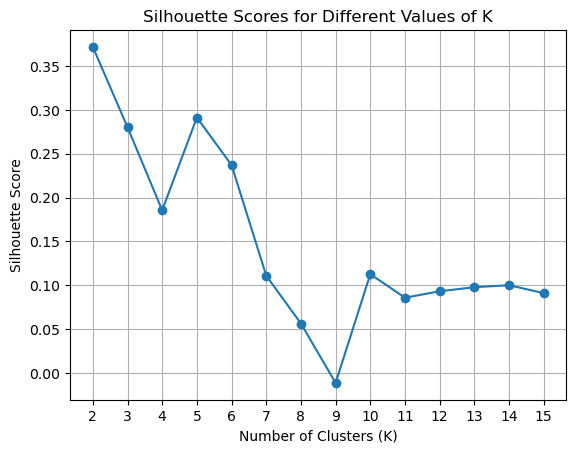

2

In [83]:
k = find_optimal_k(ta_0_messages_embeddings, show_plot=True)
k

It looks like a k of 2 is the best.

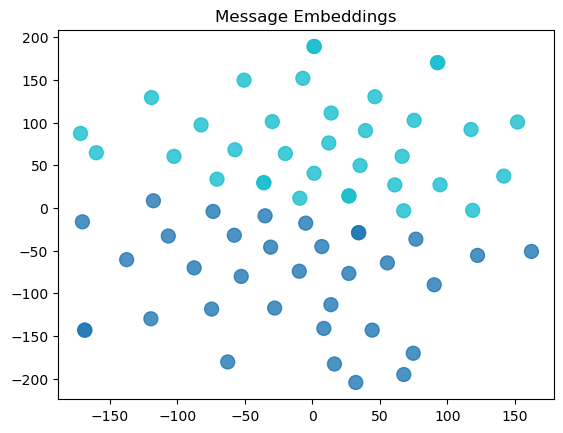

In [84]:
show_message_embeddings_communities(ta_0_messages_embeddings_compressed, None, n_clusters=k)

In [89]:
ta_0_messages_by_cluster = group_messages_by_clusters(ta_0_messages_embeddings_compressed, ta_0_messages, k)

In [91]:
# Cluster 1
ta_0_messages_by_cluster[0]

['That is what I would expect\r\n\r\n```\r\nmain() {\r\n    fprintf(stderr, "abc\\n");\r\n    fprintf(stdout, "234\\n");\r\n}\r\n```\r\n\r\nWe have abc printed to stdout\r\nand 234 printed to stderr\r\nTwo things are happening with the command:\r\n\r\n1. The redirection sends stdout to point to the same file descriptor as stderr. Which in this case is the terminal.\r\n\r\n2. The pipe duplicates and sends stdout to the read-end of the cat process\r\n\r\nSo the question is which happens first\r\n\r\nIn this case and more generally the pipes apply first THEN the io-redirection\r\n\r\nSo part 2 would happen first THEN part 1',
 'Yes, you will need to decode it',
 'Yes',
 'You can set it to null, you can also forward on the same environment of the parent by putting in `environ`\r\n\r\nWe import it at the top of the code',
 'Note any specific clarifications or improvements that could be added to this homework in this thread',
 'For any students working on this, we do provide an automated way

These look more like technical messages/suggestions for code-related problems.

In [92]:
# Cluster 2
ta_0_messages_by_cluster[1]

['We are working on it, and will post an update when it is finished',
 "Kind of, you'll be asked to identify the behavior for code, and to select the most appropriate line from a list to put into a spot to induce behavior\r\n\r\nYou will not be expected to write correct code from scratch from memory",
 'Sorry for getting to you late, for no class days and holidays we will not hold TA hours (unless otherwise stated)',
 'The testing center has different hours today',
 'no answers are given, all the sections give some code and ask you to predict the output, you can test it by actually running the code and seeing if your predictions match what you expected',
 'At the moment I think there are no plans to curve the exam. I will talk to the Professor about this during our next meeting',
 "That's a great question, and I have no idea what the answer to that is.\r\n\r\nI think if you have a problem with the way a specific question was graded (maybe the question was ambiguously worded or similar)

These look more like business and general instruction/clarification messages

In [103]:
print(len(ta_0_messages_by_cluster[0]), len(ta_0_messages_by_cluster[1]))

34 35


Unlike before, there's roughly an even split between the two key types of messages.

### What types of messages did students send?

In [93]:
student_nodes = set()

for _, row in nodes_data[['node', 'value']].iterrows():
    node_id, node_value = row['node'], row['value']
    if node_value == 'Student':
        student_nodes.add(node_id)

student_messages = [message for message in edges_data[edges_data['source'].isin(student_nodes)]['content'] if isinstance(message, str)]
student_messages_embeddings = np.array([vectorize_message(nlp, message) for message in student_messages])
assert len(student_messages) == len(student_messages_embeddings)
student_messages_embeddings.shape

(715, 300)

In [96]:
student_messages_embeddings_compressed = TSNE(n_components=2).fit_transform(student_messages_embeddings)
print(student_messages_embeddings_compressed.shape)

(715, 2)


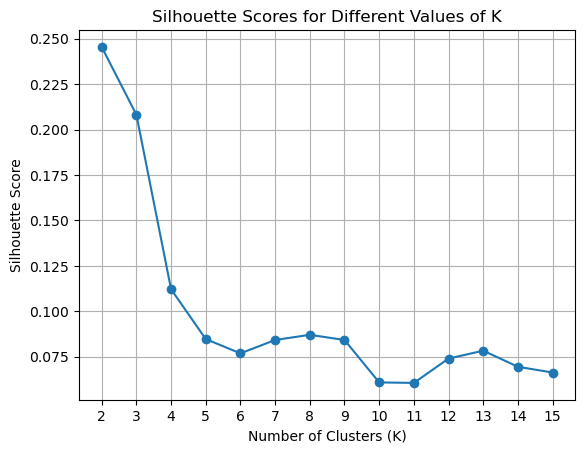

2

In [97]:
k = find_optimal_k(student_messages_embeddings, show_plot=True)
k

It looks like a k of 2 is the best.

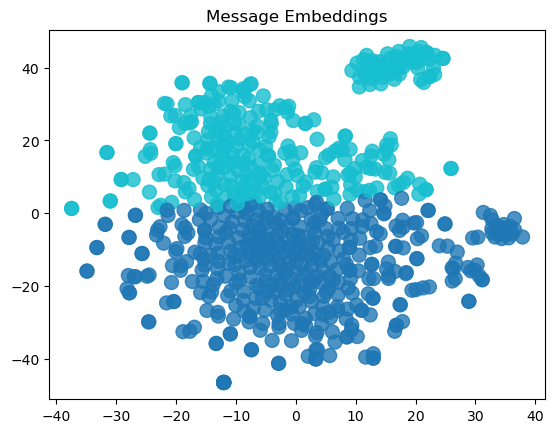

In [98]:
show_message_embeddings_communities(student_messages_embeddings_compressed, None, n_clusters=k)

In [99]:
student_messages_by_cluster = group_messages_by_clusters(student_messages_embeddings_compressed, student_messages, k)

In [100]:
# Cluster 1
student_messages_by_cluster[0]

['Not I',
 "I was on a lab computer and this happened? I didn't even have a terminal or program interface running. What do I do?",
 "How do I access the values of jobs in the job array? I was trying to use things like jobs[jobID].state but I've realized the value it returns is always 0 instead of what it's supposed to be",
 'Use the functions already written for you. I think they are getjobpid() and getjobjid()',
 'Its a struct (the members are public), so you can just access and reassign them anytime',
 'I copied all the #include statements from the client.c homework it kept referencing and I never encountered any issues with missing libraries after that',
 'Thanks! That was definitelly my problem haha',
 "~~I'll try it, it's just weird it's never happened before haha~~it worked! Thanks 😊",
 'Dono if it’ll fix it, but I had a similar problem last semester and just continuing right up until payment fixed the displayed price',
 'https://github.com/b09/c_resources/blob/master/Computer%20

In [101]:
# Cluster 2
student_messages_by_cluster[1]

['Has anyone had their Bandit assignment graded yet? Mine is still blank',
 'For the strings questions, why does S2 contain the word "Hello"? I couldn\'t figure that out, and my only remaining guess is that it overlaps the memory of S1 or S3 somehow',
 "I'm guessing you're in part 2, right? If you look up the man page for memcpy, the last line of my screenshot (at the beginning of part 2, before question 10) should answer your question!",
 "The first checkpoint of Lab 2 is almost identical to Lab 1's, with the exception of adding signals, so it's completely reasonable to copy over your work from the last lab as a basis",
 "Someone look over my logic for Level 3, because I'm getting error 132 (wrong remote port):\r\n•initialize an unsigned int sum with value 0\r\n•parse remote port\r\n•convert remote port to short host order\r\n•add the new port value to the sum\r\n•repeat these steps m times\r\n•add 1 to the summed nonce, and convert it to long network order",
 "I will be handling exam

In [102]:
print(len(student_messages_by_cluster[0]), len(student_messages_by_cluster[1]))

421 294


It looks like the first cluster primarily contains technical messages, while the second cluster contains general messages.  Base on this, it would seem that students might need more technical help with this class (compared to 236, where it seemed that most messages were general).

### Let's use the network structure and a GCN to get more message info - first, we'll try using community as message labels

In [104]:
message_interactions_handler = message_interactions(graph_handler)

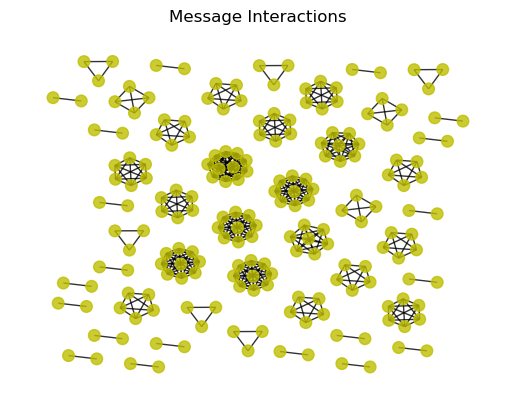

The Louvain algorithm found 48 partitions.


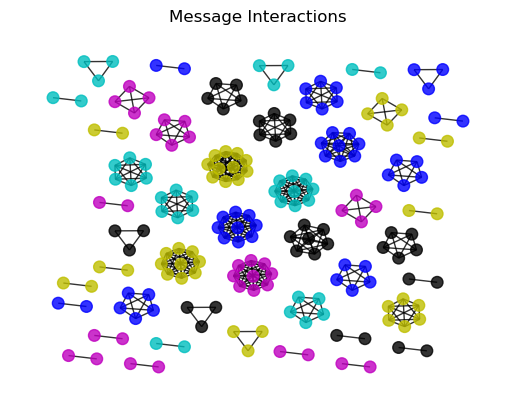

In [105]:
message_interactions_handler.showGraph(title='Message Interactions', with_labels=False)
message_interactions_handler.showLouvainCommunities(title='Message Interactions')

Similar to what we saw with the 236 graph (unsurprisingly), most messages appear to occur in larger project channels (node communities in the middle of the plot).  However, even the larger communities are not as dense as the 236 graph; perhaps this is because students further along in their studies do not need as much help (i.e. they have more experience), so they send fewer messages.

In [106]:
x, y = get_message_gcn_data(nlp, message_interactions_handler)
data = create_pytorch_data(message_interactions_handler.getGraph(), x, y)
adjacency_matrix = nx.adjacency_matrix(message_interactions_handler.getGraph()).astype(np.float32).toarray()
n_communities = len(message_interactions_handler.get_louvain_communities())

In [107]:
model = GCN(64, 32, 8, n_communities)
model

GCN(
  (hidden_layer_1): GCNConv(300, 64)
  (hidden_layer_2): GCNConv(64, 32)
  (hidden_layer_3): GCNConv(32, 8)
  (output_layer): Linear(in_features=8, out_features=48, bias=True)
)

In [108]:
embedding = train_model(data, model)
embedding.shape

Final loss: 0.03815976902842522
Final accuracy: 0.8730964467005076


torch.Size([197, 8])

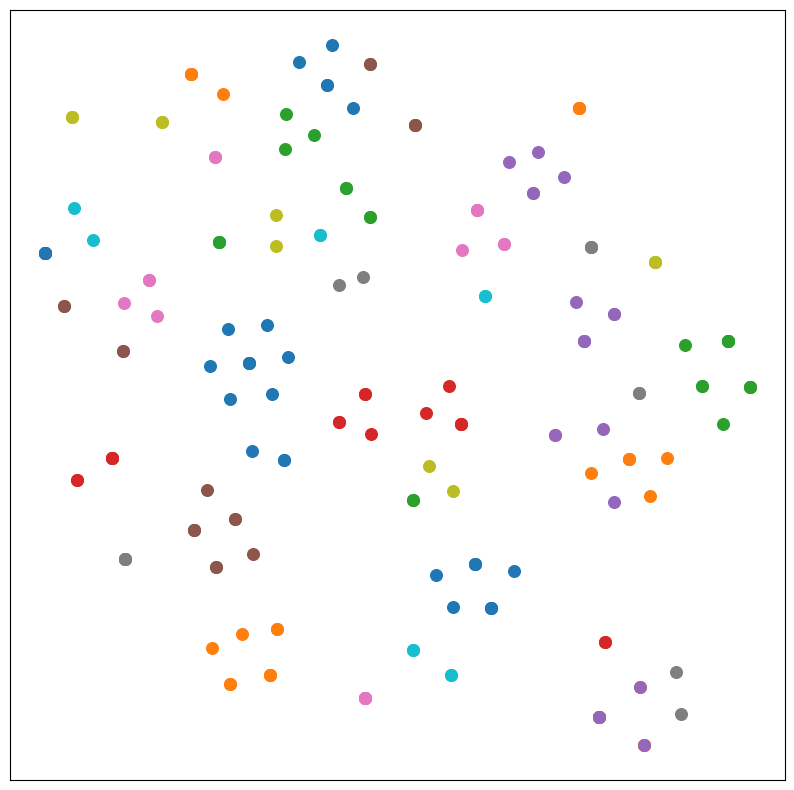

In [109]:
visualize(embedding, y)

/Users/mymac/miniforge3/envs/575/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


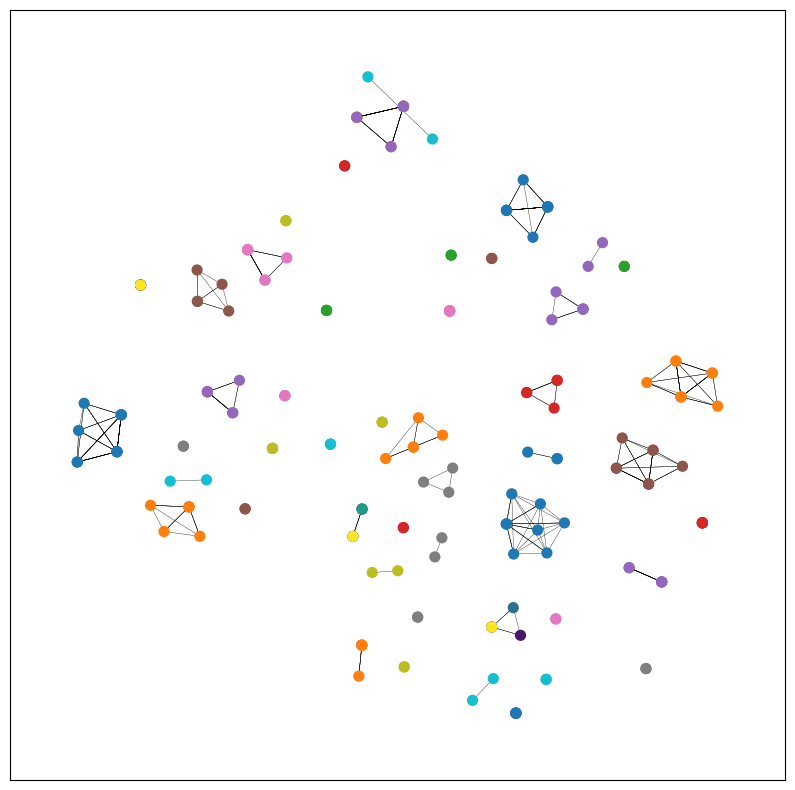

In [110]:
visualize_with_edges(message_interactions_handler, embedding)

It looks like we were able to, at least somewhat successfully, learn a two-dimensional embedding of the messages, especially for messages in large components (likely project messages).  While this might be useful for determining which channel/thread a message might belong to, it doesn't tell us as much about message content.  We'll explore this in the next section.

### Let's do the same thing (get message embeddings from a GCN), but hand-label a few messages by their "type"

In [111]:
nodes_with_messages = []

for node, attrs in message_interactions_handler.getGraph().nodes(data=True):
    assert attrs['node_type'] == 'message'
    message = attrs['node_value']
    nodes_with_messages.append((node, message))

len(nodes_with_messages)

197

In [113]:
random.sample(nodes_with_messages, int(len(nodes_with_messages) * 0.1))

[(165,
  'It seems like those are only available through an online version of the textbook. However, there are videos on YouTube that could help if you search the textbook and a specific chapter'),
 (128,
  'The late policy is linked in the syllabus, might be able to find some of these in there, its kinda complicated to explain over text haha'),
 (17,
  'no answers are given, all the sections give some code and ask you to predict the output, you can test it by actually running the code and seeing if your predictions match what you expected'),
 (178, 'No forking for that one.  I would look into handler 8'),
 (134,
  "That's what I did and it mostly works- in class the professor also recommended using the homework for the initial setup"),
 (170,
  'the parameters of open will look like this: int open(const char *pathname, int flags, mode_t mode);\r\nwhen using stdout_redir[0] for argv, since stdout_redir[] is not a pointer, you dont have to dereference it by using the asterisk'),
 (149,


In [114]:
class_label_mapping = {0: 'Clarification Response', 1: 'Error Question', 2: 'Technical Question', 
                       3: 'Response with Follow-Up', 4: 'Recommendation', 5: 'Clarification Question'}

hand_labels = {43: 4, 169: 2, 71: 2, 39: 4, 120: 1, 105: 2, 80: 4, 8: 4, 78: 0, 23: 0, 100: 3, 103: 2, 126: 3, 48: 0, 56: 0, 162: 2, 85: 3, 194: 4, 46: 4, 51: 5}

In [115]:
x, y = get_message_gcn_data(nlp, message_interactions_handler, hand_labels)
data = create_pytorch_data(message_interactions_handler.getGraph(), x, y, hand_labels=hand_labels)
adjacency_matrix = nx.adjacency_matrix(message_interactions_handler.getGraph()).astype(np.float32).toarray()
n_classes = len(np.unique(y))

In [116]:
model = GCN(64, 32, 8, n_classes)
model

GCN(
  (hidden_layer_1): GCNConv(300, 64)
  (hidden_layer_2): GCNConv(64, 32)
  (hidden_layer_3): GCNConv(32, 8)
  (output_layer): Linear(in_features=8, out_features=6, bias=True)
)

In [117]:
embedding = train_model(data, model, semi_supervised=True)
embedding.shape

Final loss: 0.16481070220470428
Final accuracy: 0.09137055837563451


torch.Size([197, 8])

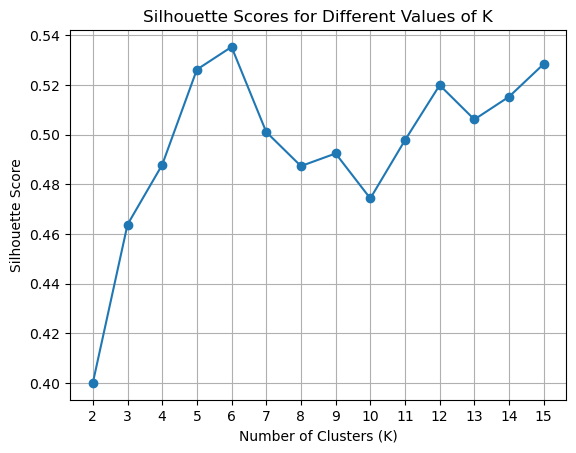

6

In [119]:
compressed_embeddings = TSNE(n_components=2).fit_transform(embedding.detach().cpu().numpy())
k = find_optimal_k(compressed_embeddings, show_plot=True)
k

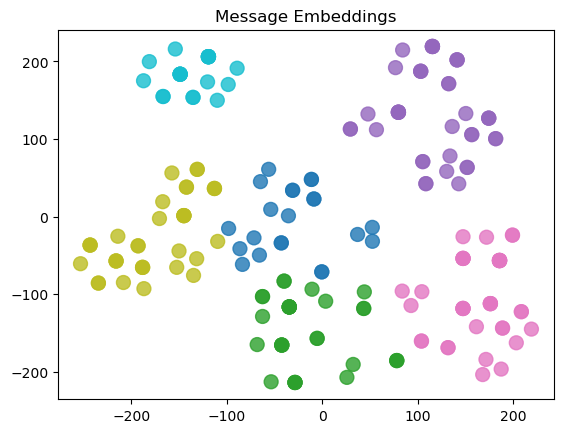

In [120]:
kmeans = get_clusters(compressed_embeddings, num_clusters=k)
show_message_embeddings_communities(compressed_embeddings, kmeans, n_clusters=k)

Unlike the 236 graph, we have the same number of clusters as the number of hand labels (6); however, we can see that the GCN still seemed to do a good job of learning message embeddings, because, similar to the 236 graph, the clusters appear to be pretty distinct.

### What types of messages did the most influential students send?

##### Student 142838701429072772128655441259243143722

In [121]:
student_node = '142838701429072772128655441259243143722'
student_message_indices = []

for node, attrs in message_interactions_handler.getGraph().nodes(data=True):
    if attrs['sender'] == student_node:
        student_message_indices.append(node)

student_message_embeddings = compressed_embeddings[student_message_indices]
student_message_embeddings.shape

(40, 2)

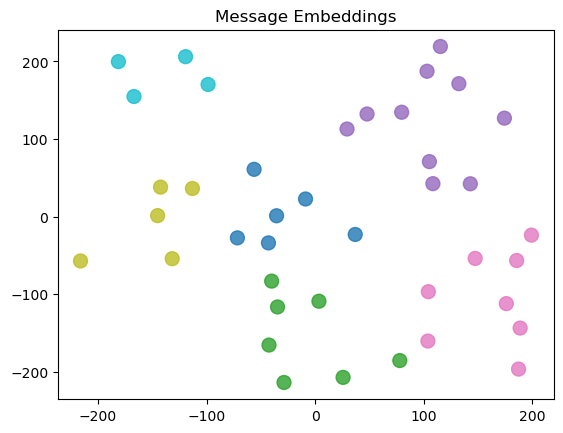

In [122]:
show_message_embeddings_communities(student_message_embeddings, kmeans, n_clusters=k)

In [123]:
print_cluster_counts(kmeans, student_message_indices, 3)

[(2, 10), (3, 8), (1, 7)]


In [124]:
print_cluster_messages(kmeans.labels_, student_message_indices, 2, message_interactions_handler.getGraph())

CLUSTER 2
---------------------------------------------------------------
I have a pdf version of the textbook and can confirm- the sections listed in the assignment aren't accurate to where the answers are found- if you look at the weekly schedule, you'll want to read 11.4-6, as well as the man pages for udp, tcp, send, and recv to find answers
---------------------------------------------------------------

---------------------------------------------------------------
Are we allowed to ask questions about specific bandit levels? I'm unclear on the instructions for level 5 (as in, I am in level 5 getting the password to 6)
---------------------------------------------------------------

---------------------------------------------------------------
I’d say yes, it’s just a little harder before class sometimes
---------------------------------------------------------------

---------------------------------------------------------------
Read the spec about handler 7 and blocking sig

These look more like clarification responses and recommendations

In [125]:
print_cluster_messages(kmeans.labels_, student_message_indices, 3, message_interactions_handler.getGraph())

CLUSTER 3
---------------------------------------------------------------
Have you run make inside of cgi bin?
---------------------------------------------------------------

---------------------------------------------------------------
Is there a pause between hitting enter on the command and it returning? Thats a common issue
---------------------------------------------------------------

---------------------------------------------------------------
I set them to null and there weren't issues regarding that- you aren't reusing those variables anywhere else so it should be good
---------------------------------------------------------------

---------------------------------------------------------------
The argv you pass to parseline is an empty array that parseline fills in for you- there is a constant given for the max length of argv you can use
---------------------------------------------------------------

---------------------------------------------------------------
Wai

These also look like clarification responses/recommendations, but perhaps a bit more technical in nature

In [126]:
print_cluster_messages(kmeans.labels_, student_message_indices, 1, message_interactions_handler.getGraph())

CLUSTER 1
---------------------------------------------------------------
ssh appears to be really struggling at the moment- best option is to try using the vpn and be patient with loading (if you keep quitting and retrying while its still loading you may have a harder time getting in)
---------------------------------------------------------------

---------------------------------------------------------------
43 doesn't manipulate totread, it manipulates buf- it should change the output of buf
---------------------------------------------------------------

---------------------------------------------------------------
Are you failing with image files?
---------------------------------------------------------------

---------------------------------------------------------------
That’s how it works- type control+d to stop it
---------------------------------------------------------------

---------------------------------------------------------------
It closes when the testing cen

Recommendations and follow-up responses

##### Student 83544633018077664925644463261004707254

In [127]:
student_node = '83544633018077664925644463261004707254'
student_message_indices = []

for node, attrs in message_interactions_handler.getGraph().nodes(data=True):
    if attrs['sender'] == student_node:
        student_message_indices.append(node)

student_message_embeddings = compressed_embeddings[student_message_indices]
student_message_embeddings.shape

(14, 2)

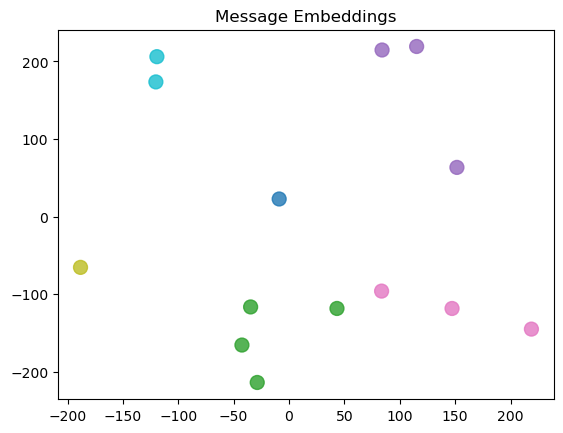

In [128]:
show_message_embeddings_communities(student_message_embeddings, kmeans, n_clusters=k)

In [129]:
print_cluster_counts(kmeans, student_message_indices, 3)

[(1, 4), (3, 3), (2, 3)]


Same clusters as the most influential student, just with fewer messages

### What were the most common messages?

In [130]:
message_indices = [node for node in message_interactions_handler.getGraph().nodes]

message_embeddings = compressed_embeddings[message_indices]
message_embeddings.shape

(197, 2)

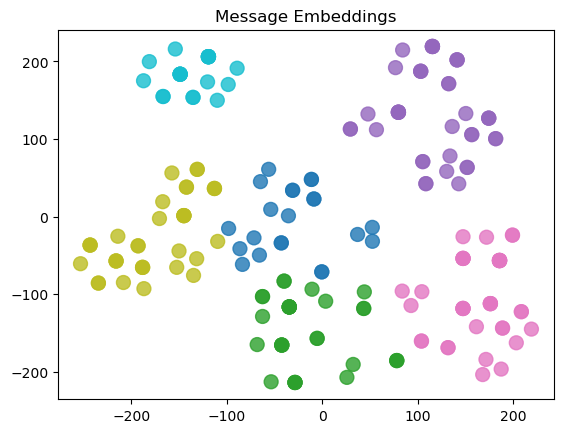

In [131]:
show_message_embeddings_communities(message_embeddings, kmeans, n_clusters=k)

In [132]:
print_cluster_counts(kmeans, message_indices, 3)

[(2, 42), (3, 41), (4, 36)]


In [133]:
print_cluster_messages(kmeans.labels_, message_indices, 2, message_interactions_handler.getGraph())

CLUSTER 2
---------------------------------------------------------------
Hey @everyone ! Make sure you're getting started on Lab 1 asap rocky if you haven't already!! You can find a nice little reference to help you get started on LearningSuite under Content->Class Resources->Lecture Slides->Additional slides->Processes, fork, exec, pipe, and file descriptors. It explains the functions and processes really well. Happy coding!
---------------------------------------------------------------

---------------------------------------------------------------
Make sure to check the TA hours sheet! It should be referenced in the <#1194025637288099891>
---------------------------------------------------------------

---------------------------------------------------------------
That is what I would expect

```
main() {
    fprintf(stderr, "abc\n");
    fprintf(stdout, "234\n");
}
```

We have abc printed to stdout
and 234 printed to stderr
Two things are happening with the command:

1. The re

Similar to what we saw with the most influential student, these look more like clarification responses and recommendations

In [134]:
print_cluster_messages(kmeans.labels_, message_indices, 3, message_interactions_handler.getGraph())

CLUSTER 3
---------------------------------------------------------------
The command cat will take the contents or output of a file and print it to stdout. Does that answer your question?
---------------------------------------------------------------

---------------------------------------------------------------
You'll still want to make sure that you iterate through the list until you connect properly using socket, after which you should break out of the loop.
---------------------------------------------------------------

---------------------------------------------------------------
Make sure to check the TA hours sheet! It should be referenced in the <#1194025637288099891>
---------------------------------------------------------------

---------------------------------------------------------------
You'll still want to make sure that you iterate through the list until you connect properly using socket, after which you should break out of the loop.
---------------------------

Also similar to what we saw with the most influential student, these also look like clarification responses/recommendations, but perhaps a bit more technical in nature

In [136]:
print_cluster_messages(kmeans.labels_, message_indices, 4, message_interactions_handler.getGraph())

CLUSTER 4
---------------------------------------------------------------
Great question! Sadly, you cannot step through the forked child process, but you can step through the parent process just fine. Print statements are your best friend for forked processes! And make sure to use fflush(stdout); after each print statement
---------------------------------------------------------------

---------------------------------------------------------------
My hours will be online this morning but I will be in-person for my afternoon hours
---------------------------------------------------------------

---------------------------------------------------------------
We are working on it, and will post an update when it is finished
---------------------------------------------------------------

---------------------------------------------------------------
Yes
---------------------------------------------------------------

---------------------------------------------------------------
Yes,

It looks like these are more business-related messages (TA hours, exam reviews, etc.)

### What types of messages did the most influential TA send?

In [137]:
ta_node = '195069161412893074299514468536466378104'
ta_message_indices = []

for node, attrs in message_interactions_handler.getGraph().nodes(data=True):
    if attrs['sender'] == ta_node:
        ta_message_indices.append(node)

ta_message_embeddings = compressed_embeddings[ta_message_indices]
ta_message_embeddings.shape

(38, 2)

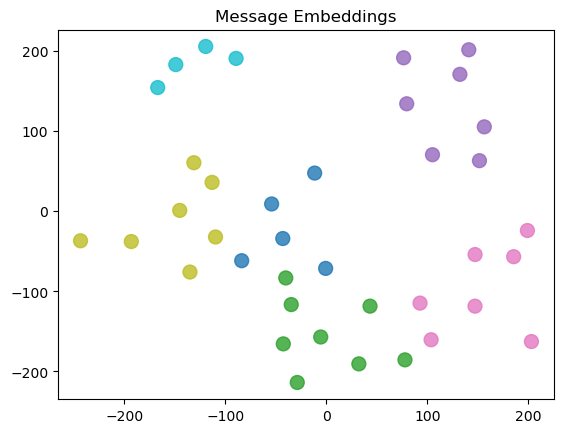

In [138]:
show_message_embeddings_communities(ta_message_embeddings, kmeans, n_clusters=k)

In [139]:
print_cluster_counts(kmeans, ta_message_indices, 3)

[(1, 8), (4, 7), (3, 7)]


Similar to the most influential student, but with a good amount of messages in cluster 4 (business-related messages)

### Out of curiousity, how much different are the message embeddings from a traditional autoencoder?

In [140]:
class Autoencoder(Module):
    def __init__(self, in_dimension):
        super(Autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_dimension, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 8)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, in_dimension)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

def get_message_autoencoder_data(nlp, handler: graphHandler) -> np.array:
    graph = handler.getGraph()
    x = []

    for node, attrs in graph.nodes(data=True):
        assert attrs['node_type'] == 'message'
        message = attrs['node_value']
        x.append(vectorize_message(nlp, message))

    return np.array(x)

def train_autoencoder(data, model, n_epochs: int = 1000):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    def _train(data):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data)
        loss.backward()
        optimizer.step()

        return loss

    for epoch in range(n_epochs):
        loss = _train(data)

    print(f'Final loss: {loss.item()}')

In [141]:
x = get_message_autoencoder_data(nlp, message_interactions_handler)

In [142]:
model = Autoencoder(x.shape[-1])
train_autoencoder(Tensor(x), model)

Final loss: 0.1155761331319809


In [143]:
with torch.no_grad():
    model.eval()
    message_embeddings = model.encoder(Tensor(x)).numpy()

message_embeddings.shape

(197, 8)

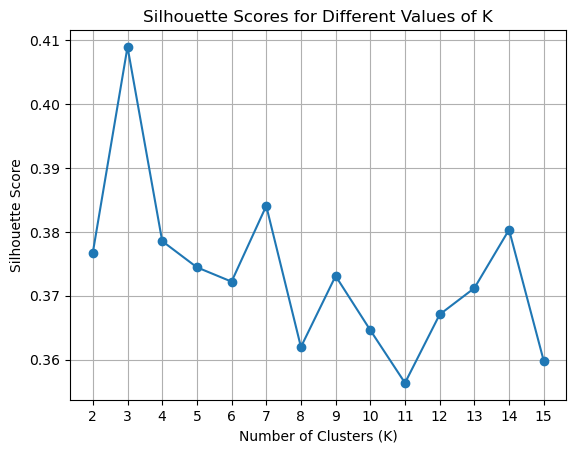

3

In [149]:
compressed_embeddings = TSNE(n_components=2).fit_transform(message_embeddings)
k = find_optimal_k(compressed_embeddings, show_plot=True)
k

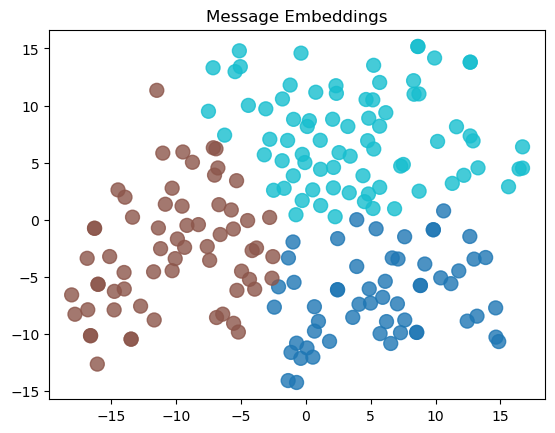

In [150]:
kmeans = get_clusters(compressed_embeddings, num_clusters=k)
show_message_embeddings_communities(compressed_embeddings, kmeans, n_clusters=k)

It appears that the autoencoder learned something similar as the GCN, though there are only 3 clusters now instead of 6; this is similar to what we saw with the 236 graph, though the autoencoder learned 4 clusters in that case.

Summary:
<ul>
    <li> The structure of most influential TAs and students is similar between the 236 and 324 graphs.
    <li> There are similarities between the two graphs in regards to message analysis/structure, though there are also some minor differences, especially with the number of learned message clusters by the GCN.  This could be due to class differences, but one thing that is notable is the number of messages in the 236 graph compared to the 324 graph; in and of itself this observation is perhaps evidence that younger students require more help, and therefore send more messages.
</ul>